In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras import Sequential, Input, layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from PIL import Image

2025-09-03 12:33:38.994582: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Maintenant tu peux importer ton module
import inspiart.dataset_prep as dp

# Import the dataset

In [8]:
file_path="data_sampling1000_topstyles10.csv"
df = pd.read_csv(file_path)
df.head()

,artist,style,movement,tags,url,img,file_name,genre_list,Artwork,Date
0,Panayiotis Tetsis,Impressionism,Post-Impressionism,NaN,https://www.wikiart.org/en/panayiotis-tetsis/s...,https://uploads3.wikiart.org/images/panayiotis...,127519-sunset.jpg,['cloudscape'],NaN,NaN
1,Henry Scott Tuke,Impressionism,Impressionism,"['Fun', 'Vacation', 'summer']",https://www.wikiart.org/en/henry-scott-tuke/th...,https://uploads5.wikiart.org/00261/images/henr...,100529-henry-scott-tuke-the-bathers-1922.jpg,['genre painting'],NaN,NaN
2,Alfred Sisley,Impressionism,Impressionism,"['fires-and-floods', 'forests-and-trees', 'Ban...",https://www.wikiart.org/en/alfred-sisley/the-f...,https://uploads1.wikiart.org/images/alfred-sis...,92312-the-flood-on-the-road-to-saint-germain-1...,['landscape'],NaN,NaN
3,Camille Pissarro,Impressionism,Impressionism,"['Grassland', 'Meadow', 'Pasture', 'Plain']",https://www.wikiart.org/en/camille-pissarro/ro...,https://uploads2.wikiart.org/images/camille-pi...,90106-rolling-landscape-in-winter-1875.jpg,['landscape'],NaN,NaN
4,Guy Rose,Impressionism,Impressionism,"['seas-and-oceans', 'cliffs-and-rocks', 'Bank'...",https://www.wikiart.org/en/guy-rose/grey-after...,https://uploads3.wikiart.org/images/guy-rose/g...,104411-grey-afternoon.jpg,['landscape'],NaN,NaN


In [9]:
list_styles = df['style'].unique().tolist()
list_styles

['Impressionism',
 'Romanticism',
 'Realism',
 'Expressionism',
 'Post-Impressionism',
 'Surrealism',
 'Symbolism',
 'Abstract Expressionism',
 'Neoclassicism',
 'Cubism']

In [10]:
nb_styles = len(list_styles)
nb_styles

10

In [12]:
df['file_name'].value_counts()[df['file_name'].value_counts() > 1]

Series([], Name: count, dtype: int64)

In [11]:
list_images= df['file_name'].unique().tolist()

Dowloading the dataset :

In [16]:
path = "../raw_data/sample1000BALANCED"
dp.download_sample_df(df, path)

Downloaded : 127519-sunset.jpg
Downloaded : 100529-henry-scott-tuke-the-bathers-1922.jpg
Downloaded : 92312-the-flood-on-the-road-to-saint-germain-1876.jpg
Downloaded : 90106-rolling-landscape-in-winter-1875.jpg
Downloaded : 104411-grey-afternoon.jpg
Downloaded : 122889-portrait-of-a-girl-1904.jpg
Downloaded : 96880-villa.jpg
Downloaded : 99193-girl-with-bird-at-the-king-street-bakery-1886.jpg
Downloaded : 77862-the-fruit-market.jpg
Downloaded : 104738-vase-with-carnations-1907.jpg
Downloaded : 111830-portrait-of-octave-maus-1885.jpg
Downloaded : 93885-waterloo-bridge.jpg
Downloaded : 98553-girl-knitting.jpg
Downloaded : 90075-mother-presle-montfoucault-1874.jpg
Downloaded : 98808-waterfall-in-yellowstone.jpg
Downloaded : 103470-furnace-of-elche-palm.jpg
Downloaded : 80985-mandolin-on-a-chair-1880.jpg
Downloaded : 68872-dnieper-1901-1.jpg
Downloaded : 66428-group-of-dancers-tree-décor.jpg
Downloaded : 97029-playing-by-heart-1897.jpg
Downloaded : 89440-horses-for-hire-in-a-yard.jpg
Down

# Images importing and resizing

In [ ]:
def load_and_resize_images(image_dir, list_images):
    """
    Charge toutes les images d'un dossier, les redimensionne en conservant le ratio
    avec padding noir et les retourne sous forme de tableau NumPy.

    Args:
        image_dir (str): Chemin vers le dossier contenant les images.
        target_size (tuple): Taille finale des images (largeur, hauteur).

    Returns:
        np.ndarray: Tableau de forme (n_images, hauteur, largeur, canaux)
    """
    images_list = []
    images_names = []

    for filename in list_images:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            images_names.append(filename)
            img_path = os.path.join(image_dir, filename)
            img = Image.open(img_path).convert('RGB')

            img_resized = img.resize((128, 128), Image.BICUBIC)

            # convert into an array and add to list
            img_array = np.array(img_resized)
            images_list.append(img_array)

    # Convertir la liste en tableau NumPy
    images_np = np.stack(images_list)
    return images_np, images_names

In [37]:
image_dir = "../raw_data/sample1000BALANCED"
images_np, images_names = load_and_resize_images(image_dir, list_images)

Test on images : 

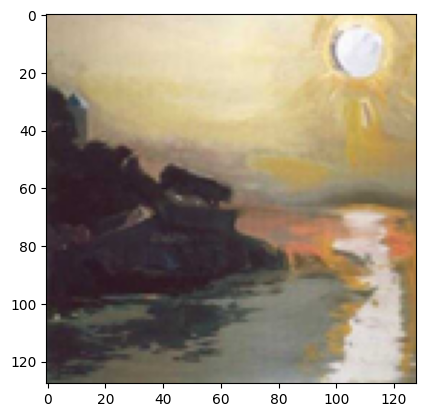

In [38]:
plt.imshow(images_np[0])

In [39]:
len(images_names)

1000

# Define X and Y

In [40]:
X =  np.array(images_np, dtype='float32') / 255.0

In [41]:
y = df['style']

# Train/test split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [43]:
### Normalizing pixels' intensities
X_train = X_train
X_test = X_test

In [44]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [45]:
### Encoding the labels
y_train_cat = to_categorical(y_train_encoded, 10).astype('float32')
y_test_cat = to_categorical(y_test_encoded, 10).astype('float32')

# Initialize a model1

In [46]:
def initialize_model(nb_styles):
    '''instanciate and return the CNN architecture of your choice with less than 150,000 params'''
    model = Sequential()
    model.add(Input(shape=(128, 128, 3)))

    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())  # normalisation pour stabiliser l'apprentissage
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

     # Bloc 2
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

     # Bloc 3
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    ### Last layer - Classification Layer with 10 outputs corresponding to 10 digits
    model.add(layers.Dense(nb_styles, activation='softmax'))

    return model

In [47]:
def compile_model(model):
    '''return a compiled model suited for the CIFAR-10 task'''
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model

In [48]:
model = compile_model(initialize_model(nb_styles))

In [49]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,486,602 (32.37 MB)

 Trainable params: 8,485,642 (32.37 MB)

 Non-trainable params: 960 (3.75 KB)

# Train the model1

In [50]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [51]:
es = EarlyStopping(patience = 5, restore_best_weights=True)
history = model.fit(X_train, y_train_cat, epochs=25, callbacks = [es], validation_split = 0.2, batch_size=32)

Epoch 1/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.1536 - loss: 3.2381 - val_accuracy: 0.1071 - val_loss: 5.6369
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.2393 - loss: 2.4954 - val_accuracy: 0.1357 - val_loss: 7.5963
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3268 - loss: 2.2619 - val_accuracy: 0.0714 - val_loss: 9.4130
Epoch 4/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.3696 - loss: 2.0396 - val_accuracy: 0.0714 - val_loss: 7.5713
Epoch 5/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4250 - loss: 1.7824 - val_accuracy: 0.0714 - val_loss: 7.0549
Epoch 6/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4714 - loss: 1.6112 - val_accuracy: 0.0714 - val_loss: 8.1322


(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

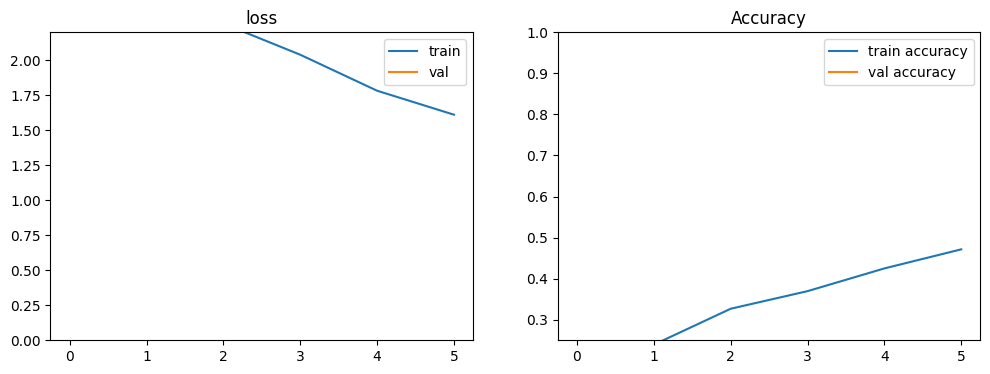

In [52]:
plot_history(history)

In [53]:
model.evaluate(X_test, y_test_cat)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.0900 - loss: 5.5235


[5.5234694480896, 0.09000000357627869]

# Evaluate the model on the 4 images 

In [66]:
import os

# Chemin du dossier
folder_path = "../raw_data/Images to try"

# Lister tous les fichiers
file_names = os.listdir(folder_path)

# Optionnel : filtrer pour ne garder que les images (jpg, png, etc.)
image_names = [f for f in file_names if f.lower().endswith((".png", ".jpg", ".jpeg", ".gif"))]

print(image_names)

['Piet_Mondriaan,_1942_-_New_York_City_I.jpg', 'Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg', 'Two_Young_Girls_at_the_Piano_MET_rl1975.1.201.R.jpg', 'Paul_Cézanne_-_The_Basket_of_Apples_-_1926.252_-_Art_Institute_of_Chicago.jpg']


In [67]:
folder_path = "../raw_data/Images to try"
images_np, images_names = load_and_resize_images(folder_path, image_names)

In [70]:
images_np.shape

(4, 128, 128, 3)

In [71]:
X_eval =  np.array(images_np, dtype='float32') / 255.0

In [72]:
X_eval.shape

(4, 128, 128, 3)

In [73]:
preds = model.predict(X_eval)
print(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
[[1.5798499e-03 3.8416779e-03 1.1856680e-02 1.5825745e-02 1.0738722e-03
  5.1675573e-02 3.4044534e-01 1.2633808e-01 9.0157175e-03 4.3834737e-01]
 [1.7059255e-04 6.1022339e-04 3.9115180e-03 5.4140450e-03 5.1767472e-07
  1.5194873e-02 4.4914860e-01 1.7475267e-01 2.9828789e-04 3.5049877e-01]
 [1.4969423e-04 5.5075181e-04 5.1689153e-03 2.9943001e-03 1.4794770e-06
  1.5939727e-02 5.1620877e-01 8.6091712e-02 4.5861004e-04 3.7243599e-01]
 [1.7356353e-04 5.5244390e-04 4.4454620e-03 3.2097958e-03 1.5644055e-06
  1.5743375e-02 4.4823200e-01 1.0374046e-01 4.5866458e-04 4.2344275e-01]]


In [ ]:
# index des classes prédites
pred_indices = preds.argmax(axis=1)
# convertit en labels d'origine
pred_labels = le.inverse_transform(pred_indices)
pred_labels

array(['Symbolism', 'Realism', 'Realism', 'Realism'], dtype=object)

In [75]:
for img_name, label, pred in zip(image_names, pred_labels, preds):
    print(f"{img_name} : {label} ({pred.max():.2f})")

Piet_Mondriaan,_1942_-_New_York_City_I.jpg : Symbolism (0.44)
Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg : Realism (0.45)
Two_Young_Girls_at_the_Piano_MET_rl1975.1.201.R.jpg : Realism (0.52)
Paul_Cézanne_-_The_Basket_of_Apples_-_1926.252_-_Art_Institute_of_Chicago.jpg : Realism (0.45)


In [ ]:
# Sauvegarder le modèle en format Keras (meilleur si possible)
from tensorflow import keras
#keras.saving.save_model(model, filepath='../models/mymodel', save_format='tf')
#keras.saving.save_model(model, filepath='../models/mymodel.h5', save_format='h5')
keras.saving.save_model(model, filepath='../models/mymodel.keras', save_format='keras')

In [ ]:
#load the model
#model = keras.saving.load_model('../models/mymodel')
#model = keras.saving.load_model('../models/mymodel.h5')
model = keras.saving.load_model('../models/mymodel.keras')